In [1]:
df = spark.sql("SELECT * FROM LH_test.dataset1.personality_dataset LIMIT 1000")
display(df)

StatementMeta(, 601c693b-6b14-45a6-b4b6-7f48fbd6fc58, 3, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 7600a62e-ea73-4660-9f82-dcba12b6722c)

# Automated ML
## Introduction

This notebook is automatically generated by the Fabric low-code AutoML wizard based on your selections. Whether you're building a regression model, a classifier, or another machine-learning solution, this tool simplifies the process by transforming your goals into executable code. You can easily modify any settings or code snippets to better align with your requirements.

### What is FLAML?

[FLAML (Fast and Lightweight Automated Machine Learning)](https://aka.ms/fabric-automl) is an open-source AutoML library designed to quickly and efficiently find the best machine learning models and hyperparameters. FLAML optimizes for speed, accuracy, and cost, making it an excellent choice for a wide range of machine-learning tasks.

### Steps in this notebook

1. **Load the data**: Import your dataset.
2. **Generate features**: Automatically transform and preprocess your data to improve model performance.
3. **Use AutoML to find your best model**: Use FLAML to automatically select the most suitable model and optimize its parameters.
4. **Save the final machine learning model**: Store the trained model for future use.
5. **Generate predictions**: Use the saved model to predict outcomes on new data.

> [!IMPORTANT]
> **Automated ML is currently supported on Fabric Runtimes 1.2+ or any Fabric environment with Spark 3.4+.**


In [40]:
%pip install scikit-learn==1.5.1

StatementMeta(, 601c693b-6b14-45a6-b4b6-7f48fbd6fc58, 73, Finished, Available, Finished)


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.



### Default notebook optimization

This cell configures the logging and warning settings to reduce unnecessary output and focus on critical information. It suppresses specific warnings and logs from the underlying libraries, ensuring a cleaner and more readable notebook experience.

In [41]:
import logging
import warnings
 
logging.getLogger('synapse.ml').setLevel(logging.CRITICAL)
logging.getLogger('mlflow.utils').setLevel(logging.CRITICAL)
warnings.simplefilter('ignore', category=FutureWarning)
warnings.simplefilter('ignore', category=UserWarning)

StatementMeta(, 601c693b-6b14-45a6-b4b6-7f48fbd6fc58, 75, Finished, Available, Finished)

## Step 1: Load the Data

This cell is responsible for importing the raw data from the specified source into the notebook environment. The data could come from various sources, such as a file or table in your lakehouse.

Once loaded, this data will serve as the input for subsequent steps, such as data transformation, model training, and evaluation.

In [53]:
import re
import pandas as pd
import numpy as np

df = spark.read.format("delta").load(
    "Tables/dataset1/personality_dataset"
).cache()
# Transform to pandas according to the selected models
X = df.limit(100000).toPandas() # Use df.toPandas() to use all the data
X = X.rename(columns = lambda c:re.sub('[^A-Za-z0-9_]+', '_', c))  # Replace not supported characters in column name with underscore to avoid invalid character for model training and saving

target_col = re.sub('[^A-Za-z0-9_]+', '_', "Personality")


StatementMeta(, 601c693b-6b14-45a6-b4b6-7f48fbd6fc58, 87, Finished, Available, Finished)

In [54]:
display(X)

StatementMeta(, 601c693b-6b14-45a6-b4b6-7f48fbd6fc58, 88, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 40da88ee-b9e4-4a39-9d56-a2533dba80e3)

In [56]:
print(X.columns)  # pour voir si 'Personality' est encore là

StatementMeta(, 601c693b-6b14-45a6-b4b6-7f48fbd6fc58, 90, Finished, Available, Finished)

Index(['Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
       'Going_outside', 'Drained_after_socializing', 'Friends_circle_size',
       'Post_frequency', 'Personality'],
      dtype='object')


## Step 2: Generate features

Featurization is the process of transforming raw data into a format optimized for training a machine learning model. It ensures the model can access the most relevant information, significantly impacting its accuracy and performance.

This step applies various techniques to refine the data, enhance its quality, and make it compatible with the selected algorithms, helping the model learn patterns more effectively.

StatementMeta(, 601c693b-6b14-45a6-b4b6-7f48fbd6fc58, 91, Finished, Available, Finished)

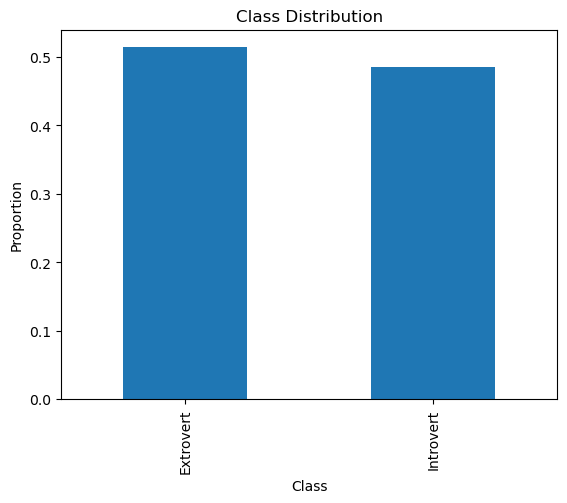

The dataset is balanced.


In [57]:
# Handle class imbalance
import matplotlib.pyplot as plt


distribution = X[target_col].value_counts(normalize=True)
dominant_class_proportion = distribution.max()

distribution.plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Proportion")
plt.show()

if dominant_class_proportion > 0.8:
    print(f"The dataset is imbalanced. The dominant class has {dominant_class_proportion * 100:.2f}% of the samples.")
    print("You may need to handle class imbalance before training the model.")
    print("You can use techniques such as oversampling, undersampling, or using class weights to handle class imbalance.")
    print("For more information, see https://aka.ms/smote-example")
else:
    print("The dataset is balanced.")


In [58]:
# Set Functions if needed for Featurization
def create_fillna_processor(
    df, mean_features=None, median_features=None, mode_features=None
):
    """
    Create a ColumnTransformer that fills missing values in a DataFrame using different strategies
    based on the skewness of the numerical features and the specified feature lists.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    mean_features (list, optional): List of features to impute using the mean strategy. Defaults to None.
    median_features (list, optional): List of features to impute using the median strategy. Defaults to None.
    mode_features (list, optional): List of features to impute using the mode strategy. Defaults to None.

    Returns:
    ColumnTransformer: A fitted ColumnTransformer that can be used to transform the DataFrame.
    list: List of all features supported by SimpleImputer in the DataFrame.
    list: List of datetime features in the DataFrame.
    """
    if mean_features is None:
        mean_features = []
    if median_features is None:
        median_features = []
    if mode_features is None:
        mode_features = []
    all_features = mean_features + median_features + mode_features
    # Group features by their imputation needs
    mean_features = [
        col
        for col in df.select_dtypes(include=["number"]).columns
        if df[col].skew(skipna=True) <= 1 and col not in all_features
    ] + mean_features
    median_features = [
        col
        for col in df.select_dtypes(include=["number"]).columns
        if df[col].skew(skipna=True) > 1 and col not in all_features
    ] + median_features
    all_features = mean_features + median_features
    datetime_features = df.select_dtypes(include=["datetime"]).columns.tolist()
    mode_features = [col for col in df.columns.tolist() if col not in all_features + datetime_features]

    transformers = []

    if mean_features:
        transformers.append(
            ("mean_imputer", SimpleImputer(strategy="mean"), mean_features)
        )
    if median_features:
        transformers.append(
            ("median_imputer", SimpleImputer(strategy="median"), median_features)
        )
    if mode_features:
        transformers.append(
            ("mode_imputer", SimpleImputer(strategy="most_frequent"), mode_features)
        )

    column_transformer = ColumnTransformer(transformers=transformers)
    all_features = mean_features + median_features + mode_features

    return column_transformer.fit(df), all_features, datetime_features


def fillna(df, processor, all_features, datetime_features):
    """
    Fill missing values in a DataFrame using a specified processor and mode imputation.

    Parameters:
    df (pd.DataFrame): The input DataFrame with missing values.
    processor (object): An object with a `transform` method that processes the DataFrame.
    all_features (list): List of all features supported by SimpleImputer in the DataFrame.
    datetime_features (list): List of datetime features in the DataFrame.

    Returns:
    pd.DataFrame: A DataFrame with missing values filled.
    """
    filled_array = processor.transform(df)
    filled_df = pd.DataFrame(filled_array, columns=all_features)
    if datetime_features:
        datetime_data = df[datetime_features]
        datetime_data.ffill()
        filled_df = pd.concat([datetime_data, filled_df], axis=1)
    for col in df.columns:
        filled_df[col].fillna(filled_df[col].mode()[0], inplace=True)

    return filled_df


StatementMeta(, 601c693b-6b14-45a6-b4b6-7f48fbd6fc58, 92, Finished, Available, Finished)

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Convertir les types
X = X.convert_dtypes()

# Définir la colonne cible avant transformation
target_col = 'Personality'

y = X[target_col]
X = X.drop(columns=[target_col])

# Convertir les colonnes object en category
for col in X.select_dtypes(include='object').columns:
    X[col] = X[col].astype('category')

# Garder uniquement les colonnes utiles
X = X.select_dtypes(include=['number', 'datetime', 'category'])

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

# Imputation
mean_features, median_features, mode_features = [], [], []
preprocessor, all_features, datetime_features = create_fillna_processor(X_train, mean_features, median_features, mode_features)
X_train = fillna(X_train, preprocessor, all_features, datetime_features)
X_test = fillna(X_test, preprocessor, all_features, datetime_features)

# Preview
display(X_train[:10])


StatementMeta(, 601c693b-6b14-45a6-b4b6-7f48fbd6fc58, 93, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 3cc23f27-3397-4b5f-a9ad-481675f6dfa7)

## Step 3: Use AutoML to find your best model

We will now use FLAML's AutoML to automatically find the best machine learning model for our data. AutoML (Automated Machine Learning) simplifies the model selection process by automatically testing and tuning various algorithms and configurations, helping us quickly identify the most effective model with minimal manual effort.

### Tracking results with experiments in Fabric

Experiments in Fabric let you track the results of your AutoML process, providing a comprehensive view of all the metrics and parameters from your trials.

In [60]:
# MLFlow Logging Related

import mlflow

mlflow.autolog(exclusive=False)
mlflow.set_experiment("classification_personality_introvert_extrovert")


StatementMeta(, 601c693b-6b14-45a6-b4b6-7f48fbd6fc58, 94, Finished, Available, Finished)

2025/06/13 14:33:32 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


<Experiment: artifact_location='', creation_time=1749822888546, experiment_id='1dd47143-c137-4764-a5de-81d71a8b2aa6', last_update_time=None, lifecycle_stage='active', name='classification_personality_introvert_extrovert', tags={}>

#### Configure the AutoML trial and settings

These configurations are driven by the AutoML mode and task selected in the wizard. For example, if you select "quick prototype", you'll see a setting for time budget.

In [61]:
# Import the AutoML class from the FLAML package
import flaml
from flaml import AutoML

# Define AutoML settings
settings = {
    "time_budget": 120, # Total running time in seconds
    "task": "binary", 
    "log_file_name": "flaml_experiment.log",  # FLAML log file
    "eval_method": "cv",
    "n_splits": 3,
    "max_iter": 10, 
    "force_cancel": True, 
    "seed": 41 , # Random seed 
    "mlflow_exp_name": "classification_personality_introvert_extrovert",  # MLflow experiment name
    "use_spark": True, # whether to use Spark for distributed training
    "n_concurrent_trials": 3,  # the maximum number of concurrent trials 
    "verbose": 1,  
    "featurization": "auto", 
}

if flaml.__version__ > "2.3.3":
    settings["entrypoint"] = "low-code"

# Create an AutoML instance
automl = AutoML(**settings)


StatementMeta(, 601c693b-6b14-45a6-b4b6-7f48fbd6fc58, 95, Finished, Available, Finished)

2025/06/13 14:33:36 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.
2025/06/13 14:33:37 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2025/06/13 14:33:37 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
2025-06-13 14:33:41.293025: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-13 14:33:41.297043: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-13 14:33:41.305259: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749825221.324105   28716 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749825221.331457 

#### Run the AutoML trial

Run the AutoML trial, with all trials being tracked as experiment runs. The trial is performed on the processed dataset, using the `Exited` variable as the target, and applying the defined configurations for optimal model selection.

In [62]:
with mlflow.start_run(nested=True, run_name="personality-AutoMLModel"):
    automl.fit(
        X_train=X_train, 
        y_train=y_train,  # target column of the training data 
    )

StatementMeta(, 601c693b-6b14-45a6-b4b6-7f48fbd6fc58, 96, Finished, Available, Finished)

[I 2025-06-13 14:33:48,046] A new study created in memory with name: optuna


[I 2025-06-13 14:34:03,740] A new study created in memory with name: optuna


2025/06/13 14:38:20 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2025/06/13 14:38:20 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/06/13 14:38:20 INFO mlflow.tracking.fluent: Autologging successfully enabled for transformers.
2025/06/13 14:38:20 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
2025/06/13 14:38:20 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.
2025/06/13 14:38:20 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2025/06/13 14:38:20 INFO mlflow.tracking.fluent: Autologging successfully enabled for pytorch_lightning.
2025/06/13 14:38:20 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.


## Step 4: Save the final machine learning model

Upon completing the AutoML trial, you can now save the final, tuned model as an ML model in Fabric.

In [63]:
model_path = f"runs:/{automl.best_run_id}/model"

# Register the model to the MLflow registry
registered_model = mlflow.register_model(model_uri=model_path, name="personality-AutoMLModel")

# Print the registered model's name and version
print(f"Model '{registered_model.name}' version {registered_model.version} registered successfully.")

StatementMeta(, 601c693b-6b14-45a6-b4b6-7f48fbd6fc58, 97, Finished, Available, Finished)

Successfully registered model 'personality-AutoMLModel'.
Created version '1' of model 'personality-AutoMLModel'.


## Step 5: Generate predictions

Microsoft Fabric lets you operationalize machine learning models with a scalable function called `PREDICT`, which supports batch scoring (or batch inferencing) in any compute engine. You can generate batch predictions directly from the Microsoft Fabric notebook or from a given ML model's item page. For more information on how to use `PREDICT`, see [Model scoring with PREDICT in Microsoft Fabric](https://aka.ms/fabric-predict).

1. Generate predictions.

In [1]:
model_name = "personality-AutoMLModel"
from synapse.ml.predict import MLFlowTransformer

feature_cols = X_train.columns.to_list()
model = MLFlowTransformer(
    inputCols=feature_cols,
    outputCol=target_col,
    modelName=model_name,
    modelVersion=registered_model.version,
)

df_test = spark.createDataFrame(X_test)
batch_predictions = model.transform(df_test)


StatementMeta(, , -1, Cancelled, , Cancelled)

In [65]:
display(batch_predictions)

StatementMeta(, 601c693b-6b14-45a6-b4b6-7f48fbd6fc58, 100, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 2fd6aecf-b4e8-4d12-a2b8-2c95bd1e51ec)

2. Save the predictions to a table.

In [66]:
saved_name = "Tables/dataset1/personality_dataset_predictions".replace(".", "_")
batch_predictions.write.mode("overwrite").format("delta").option("overwriteSchema", "true").save(saved_name)

StatementMeta(, 601c693b-6b14-45a6-b4b6-7f48fbd6fc58, 101, Finished, Available, Finished)

## Nouvelles donées à tester manuellement

In [10]:
%pip install scikit-learn==1.5.1

StatementMeta(, 3ee14948-312a-42cb-befa-3aa68c32f39e, 17, Finished, Available, Finished)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 126.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 2.2.0
    Not uninstalling threadpoolctl at /home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages, outside environment /nfs4/pyenv-6b0892a2-4adc-423e-89a7-c98d989d09fd
    Can't uninstall 'threadpoolctl'. No files were found to uninstall.
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Not uninstalling scikit-learn at /home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages, outside environment /nfs4/pyenv-6b0892a2-4adc-423e-89a7-c98d989d09fd
    Can't uninstall 'scikit-learn'. No files were found to uninstall.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nni 3.0 requires filelock<3.12, but you

In [11]:
import mlflow
from synapse.ml.predict import MLFlowTransformer
from pyspark.sql import Row

# 3. ✅ Créer le modèle MLFlowTransformer
model = MLFlowTransformer(
    inputCols=["Time_spent_Alone","Social_event_attendance","Going_outside","Friends_circle_size","Post_frequency"], # Your input columns here
    outputCol="predictions", # Your new column name here
    modelName="personality-AutoMLModel", # Your model name here
    modelVersion=1 # Your model version here
)

StatementMeta(, 3ee14948-312a-42cb-befa-3aa68c32f39e, 19, Finished, Available, Finished)

2025/06/13 15:42:11 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - astunparse (current: uninstalled, required: astunparse==1.6.3)
 - optree (current: uninstalled, required: optree==0.16.0)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/functions.py:407: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.


StatementMeta(, , -1, Finished, , Finished)

RejectSilentExecuteRequest: Livy session has failed. Error code: RejectSilentExecuteRequest. Rejected silent execute_request as there is no active session.

StatementMeta(, , -1, Finished, , Finished)

RejectSilentExecuteRequest: Livy session has failed. Error code: RejectSilentExecuteRequest. Rejected silent execute_request as there is no active session.

StatementMeta(, , -1, Finished, , Finished)

RejectSilentExecuteRequest: Livy session has failed. Error code: RejectSilentExecuteRequest. Rejected silent execute_request as there is no active session.

In [21]:
new_data = {
    "Time_spent_Alone": 10,             # la personne passe beaucoup de temps seule
    "Social_event_attendance": 0,      # elle va rarement à des événements sociaux
    "Going_outside": 0,                # sort assez régulièrement
    "Friends_circle_size": 1,          # cercle d'amis limité
    "Post_frequency": 0                # poste peu souvent sur les réseaux sociaux
}

StatementMeta(, 3ee14948-312a-42cb-befa-3aa68c32f39e, 29, Finished, Available, Finished)

Les résultats de la prédiction : 

- 0 correspond à extraverti
- 1 correspond à introverti

In [22]:
from pyspark.sql import Row

# ✅ Créer un DataFrame Spark avec cette nouvelle ligne
new_df = spark.createDataFrame([Row(**new_data)])

prediction = model.transform(new_df)
prediction.select("predictions").show()

StatementMeta(, 3ee14948-312a-42cb-befa-3aa68c32f39e, 30, Finished, Available, Finished)

+-----------+
|predictions|
+-----------+
|          1|
+-----------+

